# Lab: ISS decoding

## Using starfish pixel spot decoder

Once the data is correctly loaded and processed, we are in the position of decoding the actual ISS spots. To this end, we will use again **starfish**, find the original tutorial [here](https://spacetx-starfish.readthedocs.io/en/mcai-api-additions/gallery/tutorials/pixelbased_decoding.html#sphx-glr-gallery-tutorials-pixelbased-decoding-py):

> Pixel-based decoding is the approach of localizing and decoding<sup>1</sup> molecules (e.g. RNA transcripts or rolonies) that does not rely on algorithms to find spots by fitting Gaussian profiles or local intensity maxima. Instead of finding spots to be decoded, it decodes every pixel and then connects potential pixels with the same codeword<sup>2</sup> from the codebook<sup>3</sup>  into spots. The strength of this approach is it works on dense data and noisy data where spot finding algorithms have a hard time accurately detecting spots. The weakness is that it is prone to false positives by decoding noise that would normally be ignored by spot finding algorithms.

[1]: Matching putative barcodes to codewords in a codebook to read out the corresponding target believed to be associated with that barcode.

[2]: A codeword maps expected intensities across multiple image tiles within a field of view to the target that is encoded by the codeword.

[3]: A codebook contains all the codewords needed by an experiment to decode an IntensityTable. It also contains a mapping of channels to the integer indices that are used by starfish to represent them internally.

In [ ]:
# We install dependencies, including the latest version of starfish
!apt update
!apt install libvips tree
!pip install tissuumaps
!pip install git+https://github.com/spacetx/starfish

In [4]:
# We download some helper functions and quality control plugins

from urllib import request
import os
os.makedirs("./iss_utils", exist_ok=True)
request.urlretrieve( 'https://raw.githubusercontent.com/wahlby-lab/ISS_Decoding_colab/main/iss_utils/__init__.py' , './iss_utils/__init__.py' )
request.urlretrieve( 'https://raw.githubusercontent.com/wahlby-lab/ISS_Decoding_colab/main/iss_utils/read_starfish.py' , './iss_utils/read_starfish.py' )
request.urlretrieve( 'https://raw.githubusercontent.com/wahlby-lab/ISS_Decoding_colab/main/iss_utils/starfish2tmap.py' , './iss_utils/starfish2tmap.py' )

os.makedirs(os.path.join(os.path.expanduser("~"), ".tissuumaps", "plugins"), exist_ok = True)
for ext in [".py",".js",".yml"]:
    request.urlretrieve(
        "https://raw.githubusercontent.com/TissUUmaps/TissUUmaps/11f635fb1b9c5fa69e4d15735c1a9f833ab74af3/plugins_repo/Spot_Inspector" + ext,
        os.path.join(os.path.expanduser("~"), ".tissuumaps", "plugins", 'Spot_Inspector' + ext)
    )

We take a tile from the raw data:

In [3]:
from urllib import request
import tarfile
from tqdm import tqdm
import os

os.makedirs("./data/", exist_ok=True)
base_path = "https://export.uppmax.uu.se/snic2022-23-113/courses/spatial_omics_2022/in_situ_sequencing/"

# Download necessary tar.gz files
for tar_file in ["SpaceTX_1_fov.tar.gz"]:
    print ("Downloading " + base_path + tar_file)
    request.urlretrieve( base_path+tar_file , "./data/"+tar_file )

# Unzip tar.gz files
for tar_file in ["SpaceTX_1_fov.tar.gz"]:
    print ("Unzipping " + "./data/" + tar_file)
    tar = tarfile.open("./data/" + tar_file, "r:gz")

    progress = tqdm(tar.getmembers())
    for member in progress:
        tar.extract(member, path="./data/")
        # set the progress description of the progress bar
        progress.set_description(f"Extracting {member.name}")
    tar.close()

!tree --filelimit=100 ./data/

ModuleNotFoundError: No module named 'tqdm'

In [3]:
import tissuumaps.jupyter as tm

import numpy as np
import os
from starfish import Experiment, display
from starfish.image import Filter
from starfish.spots import DetectPixels
from starfish.types import Features, Axes

from starfish import IntensityTable
from iss_utils import starfish2tmap

INFO:root: * TissUUmaps version: 3.1.1.4
INFO:numexpr.utils:NumExpr defaulting to 2 threads.


In [10]:
input_path = './data/SpaceTX_1_fov'
sel_fov = 'fov_045'

In [ ]:
import glob

raw_images = sorted(glob.glob(input_path + "/*.tiff"))
viewer = tm.loaddata(images=raw_images, plugins=["Spot_Inspector"], compositeMode="lighter")
iss_utils.tmap_to_colab(viewer, iframe=True)

In [16]:
exp = Experiment.from_json(
    os.path.join(input_path, "experiment.json")
)
imgs_primary = exp[sel_fov].get_image('primary')
imgs_nuclei  = exp[sel_fov].get_image('nuclei')

In [17]:
imgs_primary

<starfish.ImageStack (r: 6, c: 4, z: 1, y: 2000, x: 2000)>

Following the tutorial, first we will apply high and low pass filters, designed to smooth the data before detecting the spots.

In [18]:
# filter and deconvolve data
ghp = Filter.GaussianHighPass(sigma=3)
glp = Filter.GaussianLowPass(sigma=1)

ghp.run(imgs_primary, in_place=True)
glp.run(imgs_primary, in_place=True)

100%|██████████| 24/24 [00:01<00:00, 20.93it/s]


We can compare some random tiles before and after filtering:

100%|██████████| 24/24 [00:01<00:00, 20.56it/s]


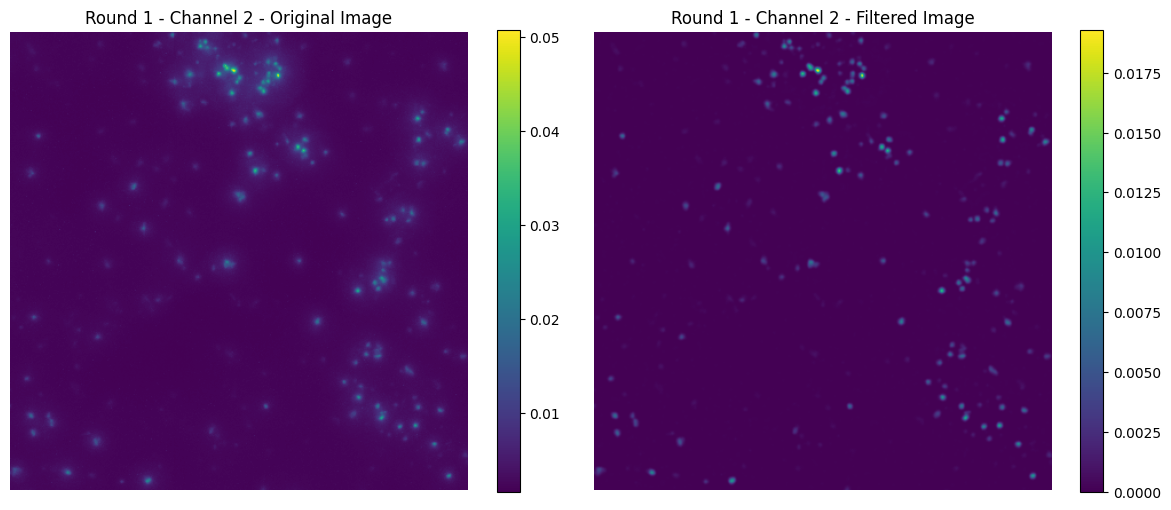

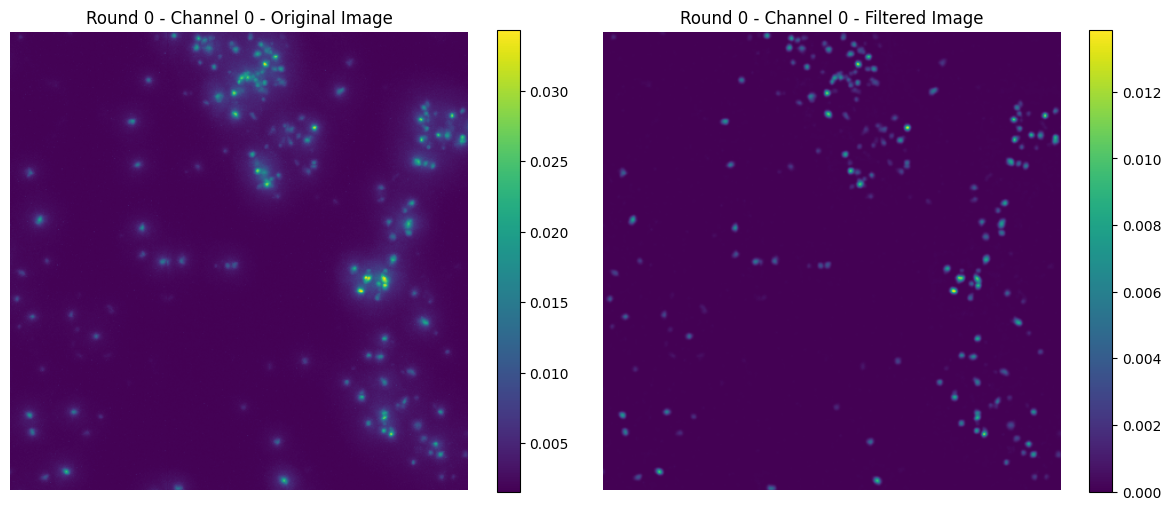

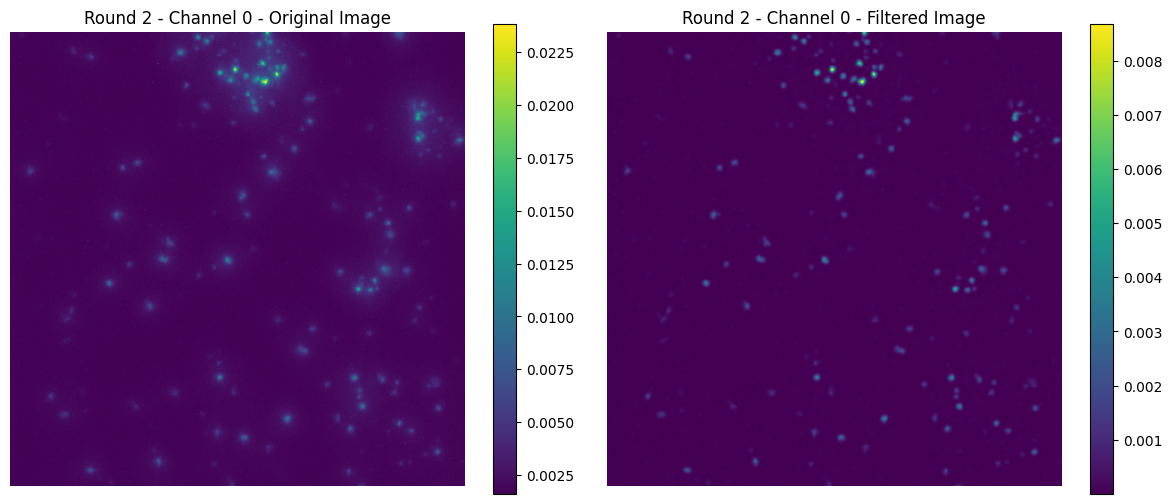

In [19]:
starfish2tmap.compare_images(
    exp[sel_fov].get_image('primary'),
    imgs_primary,
    n=3
)

We can already use some kind of decoding to detect the expressed genes. In this case, we will use a pixel spot decoder. This can yield suboptimal results in terms of detection, but we will still use if for simiplicity sake. There are other approaches for performing this such as [bardensr](https://github.com/jacksonloper/bardensr) or [ISTDECO](https://github.com/axanderssonuu/istdeco) that allow decoding with a better performance.

There are some hyperparameters that need to be tuned, but the most important input to the function is the **codebook** that contain which combination of rounds and channels (barcode) is translated to a specific gene.


In [20]:
psd = DetectPixels.PixelSpotDecoder(
    codebook=exp.codebook,
    metric='euclidean',             # distance metric to use for computing distance between a pixel vector and a codeword
    norm_order=2,                   # the L_n norm is taken of each pixel vector and codeword before computing the distance. this is n
    distance_threshold=0.5176,      # minimum distance between a pixel vector and a codeword for it to be called as a gene
    magnitude_threshold=1.77e-5,    # discard any pixel vectors below this magnitude
    min_area=2,                     # do not call a 'spot' if it's area is below this threshold (measured in pixels)
    max_area=np.inf,                # do not call a 'spot' if it's area is above this threshold (measured in pixels)
)
initial_spot_intensities, prop_results = psd.run(imgs_primary, n_processes=None)

100%|██████████| 19547/19547 [00:03<00:00, 6141.18it/s]


In [21]:
initial_spot_intensities

<xarray.DecodedIntensityTable (features: 19547, r: 6, c: 4)>
array([[[7.94557855e-03, 5.67732096e-01, 7.68309981e-02, 2.20660660e-02],
        [3.66728604e-01, 1.14881545e-01, 2.89299916e-02, 3.17189991e-02],
        [8.19781497e-02, 3.15120183e-02, 1.64351627e-01, 2.48280242e-02],
        [3.70100550e-02, 3.56204733e-02, 3.61078620e-01, 3.31461169e-02],
        [2.79763322e-02, 2.28138939e-02, 9.47471857e-02, 4.42311585e-01],
        [1.41215241e-02, 2.91018784e-01, 7.66195878e-02, 3.04936171e-02]],

       [[4.60006157e-03, 2.61445623e-03, 3.95131826e-01, 1.06802406e-02],
        [3.38571123e-03, 4.16002035e-01, 1.03080124e-01, 6.69879233e-03],
        [3.85652552e-03, 2.39919797e-02, 1.43758338e-02, 2.58558422e-01],
        [3.97995800e-01, 1.17286928e-02, 1.29713854e-02, 8.92781280e-03],
        [2.32854523e-02, 4.62912861e-03, 4.36005950e-01, 2.28768401e-02],
        [1.11891180e-02, 7.06442632e-03, 3.65332693e-01, 1.17881736e-02]],

       [[6.40728772e-01, 1.60263258e-03, 3.15804064e-04, 1.54307289e-02],
        [5.25000356e-02, 2.21829697e-01, 8.02781899e-03, 5.03326654e-02],
        [2.57465184e-01, 9.99146421e-03, 1.14519494e-02, 1.36283608e-02],
        [2.54356815e-03, 7.71685911e-04, 1.06331021e-01, 3.02884936e-01],
        [4.91352053e-03, 3.14745933e-01, 1.75186622e-04, 2.96429023e-02],
        [4.75224286e-01, 7.86789879e-02, 2.59247702e-02, 8.39774963e-04]],
...
        [6.55366182e-02, 3.25654750e-04, 3.61175090e-08, 3.79388779e-01],
        [2.30010152e-02, 3.63885192e-04, 7.39842926e-06, 7.15029240e-02],
        [5.57544816e-04, 2.60734092e-03, 6.26265824e-01, 6.54278044e-03],
        [2.56588668e-01, 5.21146460e-03, 3.29056347e-05, 1.56701013e-01],
        [1.45968422e-02, 3.24205053e-03, 5.84019814e-03, 3.50458831e-01]],

       [[1.59061776e-04, 2.02858895e-02, 5.65495610e-01, 1.29721477e-03],
        [2.25165477e-05, 1.48521224e-03, 4.99622166e-01, 1.24336162e-03],
        [6.93331566e-03, 2.24959701e-01, 1.41590217e-03, 6.79406375e-02],
        [1.64756626e-01, 2.48127035e-04, 7.10901478e-03, 2.34812662e-01],
        [2.33291052e-02, 4.49039638e-01, 7.40092434e-03, 3.51639115e-04],
        [3.79025191e-03, 2.67493635e-01, 7.92889148e-02, 1.54813724e-02]],

       [[5.94389103e-02, 2.11810708e-01, 2.87858415e-02, 2.76793629e-01],
        [1.18245175e-02, 3.52849960e-02, 2.70477999e-02, 2.07683325e-01],
        [9.36015788e-03, 2.26088792e-01, 6.82943910e-02, 1.13086887e-02],
        [1.38254091e-01, 5.07047176e-01, 1.41277234e-03, 1.40864089e-01],
        [1.22325853e-01, 9.94603615e-03, 6.61170855e-02, 3.61645162e-01],
        [3.88172157e-02, 1.53637528e-02, 5.67954063e-01, 4.82050329e-02]]],
      dtype=float32)
Coordinates: (12/14)
    z                  (features) int64 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    y                  (features) int64 0 1 0 0 0 0 ... 1999 1999 1999 1999 1999
    x                  (features) int64 39 66 136 143 ... 1257 1281 1439 1530
    target             (features) object 'Apod' 'Gfap' 'Stat1' ... 'Qdpr' 'Meg3'
    radius             (features) float64 1.871 2.585 1.382 ... 0.7979 0.5642
    spot_id            (features) int64 0 1 2 3 4 ... 19543 19544 19545 19546
    ...                 ...
  * features           (features) int64 0 1 2 3 4 ... 19543 19544 19545 19546
  * r                  (r) int64 0 1 2 3 4 5
  * c                  (c) int64 0 1 2 3
    xc                 (features) float64 1.956e+03 1.961e+03 ... 2.199e+03
    yc                 (features) float64 975.0 975.2 975.0 ... 1.3e+03 1.3e+03
    zc                 (features) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    starfish:  {"log": [{"method": "PixelSpotDecoder", "arguments": {"codeboo...

These approaches usually yield too many false positives, so it is a good dea to threshold based on random codes included for this purpose.

In [22]:
# filter spots that do not pass thresholds
spot_intensities = initial_spot_intensities.loc[initial_spot_intensities[Features.PASSES_THRESHOLDS]]

This is how the decoded intensity table looks like:

In [23]:
spot_intensities

<xarray.DecodedIntensityTable (features: 17890, r: 6, c: 4)>
array([[[7.94557855e-03, 5.67732096e-01, 7.68309981e-02, 2.20660660e-02],
        [3.66728604e-01, 1.14881545e-01, 2.89299916e-02, 3.17189991e-02],
        [8.19781497e-02, 3.15120183e-02, 1.64351627e-01, 2.48280242e-02],
        [3.70100550e-02, 3.56204733e-02, 3.61078620e-01, 3.31461169e-02],
        [2.79763322e-02, 2.28138939e-02, 9.47471857e-02, 4.42311585e-01],
        [1.41215241e-02, 2.91018784e-01, 7.66195878e-02, 3.04936171e-02]],

       [[4.60006157e-03, 2.61445623e-03, 3.95131826e-01, 1.06802406e-02],
        [3.38571123e-03, 4.16002035e-01, 1.03080124e-01, 6.69879233e-03],
        [3.85652552e-03, 2.39919797e-02, 1.43758338e-02, 2.58558422e-01],
        [3.97995800e-01, 1.17286928e-02, 1.29713854e-02, 8.92781280e-03],
        [2.32854523e-02, 4.62912861e-03, 4.36005950e-01, 2.28768401e-02],
        [1.11891180e-02, 7.06442632e-03, 3.65332693e-01, 1.17881736e-02]],

       [[6.40728772e-01, 1.60263258e-03, 3.15804064e-04, 1.54307289e-02],
        [5.25000356e-02, 2.21829697e-01, 8.02781899e-03, 5.03326654e-02],
        [2.57465184e-01, 9.99146421e-03, 1.14519494e-02, 1.36283608e-02],
        [2.54356815e-03, 7.71685911e-04, 1.06331021e-01, 3.02884936e-01],
        [4.91352053e-03, 3.14745933e-01, 1.75186622e-04, 2.96429023e-02],
        [4.75224286e-01, 7.86789879e-02, 2.59247702e-02, 8.39774963e-04]],
...
        [5.19487560e-01, 2.02504043e-02, 1.22145126e-02, 1.11775016e-02],
        [5.52826039e-02, 4.82102297e-02, 2.43264422e-01, 4.81666885e-02],
        [6.18288619e-03, 2.19806477e-01, 6.92865625e-02, 1.89970359e-01],
        [3.19934100e-01, 8.97413585e-03, 5.82577549e-02, 1.66431472e-01],
        [4.50368486e-02, 3.33186626e-01, 7.61682019e-02, 1.15971267e-01]],

       [[4.74330783e-02, 5.03593087e-01, 6.68032467e-02, 3.79461460e-02],
        [1.98386982e-02, 4.29696552e-02, 4.75818515e-02, 4.02523905e-01],
        [1.18456155e-01, 2.53950618e-02, 6.29947335e-02, 9.23200995e-02],
        [6.59276126e-03, 2.46479139e-02, 8.83755162e-02, 2.72181332e-01],
        [2.43248194e-02, 2.93502390e-01, 5.28837778e-02, 3.95030566e-02],
        [6.32914007e-02, 5.00335023e-02, 8.42920244e-02, 5.75468838e-01]],

       [[1.59061776e-04, 2.02858895e-02, 5.65495610e-01, 1.29721477e-03],
        [2.25165477e-05, 1.48521224e-03, 4.99622166e-01, 1.24336162e-03],
        [6.93331566e-03, 2.24959701e-01, 1.41590217e-03, 6.79406375e-02],
        [1.64756626e-01, 2.48127035e-04, 7.10901478e-03, 2.34812662e-01],
        [2.33291052e-02, 4.49039638e-01, 7.40092434e-03, 3.51639115e-04],
        [3.79025191e-03, 2.67493635e-01, 7.92889148e-02, 1.54813724e-02]]],
      dtype=float32)
Coordinates: (12/14)
    z                  (features) int64 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    y                  (features) int64 0 1 0 0 0 0 ... 1998 1998 1999 1999 1999
    x                  (features) int64 39 66 136 143 157 ... 1841 96 391 1439
    target             (features) object 'Apod' 'Gfap' 'Stat1' ... 'Mbp' 'Qdpr'
    radius             (features) float64 1.871 2.585 1.382 ... 1.128 0.7979
    spot_id            (features) int64 0 1 2 3 4 ... 19537 19538 19540 19545
    ...                 ...
  * features           (features) int64 0 1 2 3 4 ... 19537 19538 19540 19545
  * r                  (r) int64 0 1 2 3 4 5
  * c                  (c) int64 0 1 2 3
    xc                 (features) float64 1.956e+03 1.961e+03 ... 2.184e+03
    yc                 (features) float64 975.0 975.2 975.0 ... 1.3e+03 1.3e+03
    zc                 (features) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    starfish:  {"log": [{"method": "PixelSpotDecoder", "arguments": {"codeboo...

Example of how to access the spot attributes:

In [24]:
print(f"The area of the first spot is {prop_results.region_properties[0].area}")

The area of the first spot is 11


Let's save it before continuing with the quality control using TissUUmaps. Starfish has a method for this:

In [27]:
os.makedirs("./results", exist_ok=True)
spot_intensities.to_netcdf('./results/spot_intensities.netcdf')

# Lab 02b: ISS decoding quality control

For this last step, we will use the TissUUmaps [Spot Inspector](https://tissuumaps.github.io/tutorials/#spot_inspector) plugin to visually assess the quality of the decoding. This plugin allows to explore raw in situ sequencing data by visualizing a grid of rounds and channels and drawing the trace of the codeword that the decoding algorithm decided to assign to a particular spot. Thus, in a visual and intuitive way, one may see if the decoding corresponds to what the raw data and potentially detect some error sources.

To begin, we will load the spot intensities saved in the previous part of the lab.

In [28]:
spot_intensities = IntensityTable.open_netcdf('./results/spot_intensities.netcdf')

We developed a series of helper functions that will allow adapting the starfish files for opening in TissUUmaps. For more information, visit [the website](https://tissuumaps.github.io/tutorials/#starfish).

First, we will create a CSV file from a starfish experiments compatible with the TissUUmaps Spot Insepector plugin.

In [29]:
os.makedirs('./results/decoded', exist_ok=True)
csv_name = starfish2tmap.qc_csv(
    experiment=exp,
    spot_intensities=spot_intensities,
    output_path='./results/decoded'
)

Now, we can create the images from a starfish experiments to show for the Spot Inspector plugin.

In [30]:
image_names = starfish2tmap.qc_images(
    imgs_primary,
    imgs_nuclei,
    output_path='./results/decoded'
)

100%|██████████| 4/4 [00:00<00:00, 17.23it/s]


In [31]:
!tree --filelimit=100 ./results/decoded/

./results/decoded/
├── pixel_decoding.csv
├── Round0_0.tif
├── Round0_1.tif
├── Round0_2.tif
├── Round0_3.tif
├── Round0_DAPI.tif
├── Round1_0.tif
├── Round1_1.tif
├── Round1_2.tif
├── Round1_3.tif
├── Round1_DAPI.tif
├── Round2_0.tif
├── Round2_1.tif
├── Round2_2.tif
├── Round2_3.tif
├── Round2_DAPI.tif
├── Round3_0.tif
├── Round3_1.tif
├── Round3_2.tif
├── Round3_3.tif
├── Round3_DAPI.tif
├── Round4_0.tif
├── Round4_1.tif
├── Round4_2.tif
├── Round4_3.tif
├── Round4_DAPI.tif
├── Round5_0.tif
├── Round5_1.tif
├── Round5_2.tif
├── Round5_3.tif
└── Round5_DAPI.tif

0 directories, 31 files


Finally, we can open TissUUmaps inside this notebook and play around with the plugin. Find some good and bad examples of decodings and try to think what went wrong with a particular spot.

In [40]:
viewer = tm.loaddata(images=image_names,csvFiles= csv_name, plugins=["Spot_Inspector"], keySelector="target_name", port=5108)
iss_utils.tmap_to_colab(viewer, iframe=False)

<IPython.core.display.Javascript object>